# Analysis for figures 2, S2 and S4.

## imports & installations

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys
import itertools
import os
from scipy.stats import normaltest
from itertools import groupby

warnings.simplefilter('ignore', pd.errors.DtypeWarning)
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import analysis.calc_single_cell_properties as calculator 
import analysis.calc_auc_over_time as auc_calculator 
import analysis.utils as utils
import data_layer.utils as data_utils
from configuration import consts

## data loading - differentiation scores dataframes

In [2]:
scores_df_s3 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S3.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S3.pkl")

scores_df_s2 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S2.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S2.pkl")

scores_df_s5 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S5.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S5.pkl")

scores_df_s1 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S1.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S1.pkl")

Calculate single cell properties

In [3]:
scores_df_s3 = calculator.get_properties(scores_df_s3, vid_name="S3", actin_vid_path=consts.vid_info_dict["3"]['actin_path'])
scores_df_s2 = calculator.get_properties(scores_df_s2, vid_name="S2", actin_vid_path=consts.vid_info_dict["2"]['actin_path'])
scores_df_s5 = calculator.get_properties(scores_df_s5, vid_name="S5", actin_vid_path=consts.vid_info_dict["5"]['actin_path'])
scores_df_s1 = calculator.get_properties(scores_df_s1, vid_name="S1", actin_vid_path=consts.vid_info_dict["1"]['actin_path'])

# Models' performance

display models performance- actin intensity/motility seperately. 

We will display the following metrics:
1. accuracy
2. specificity
3. sensitivity 
4. precision
5. AUC

We will display the following graphs:
1. ROC curve
2. AUC over time

Evaluation metrics for motility based model, tested on videos (s2, s3):
accuracy: 0.76
specificity: 0.917
sensitivity (recall): 0.711
precision: 0.965
AUC: 0.814


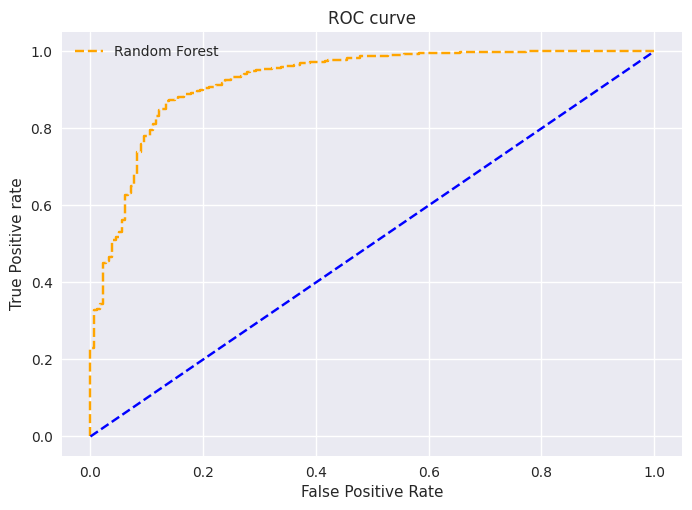

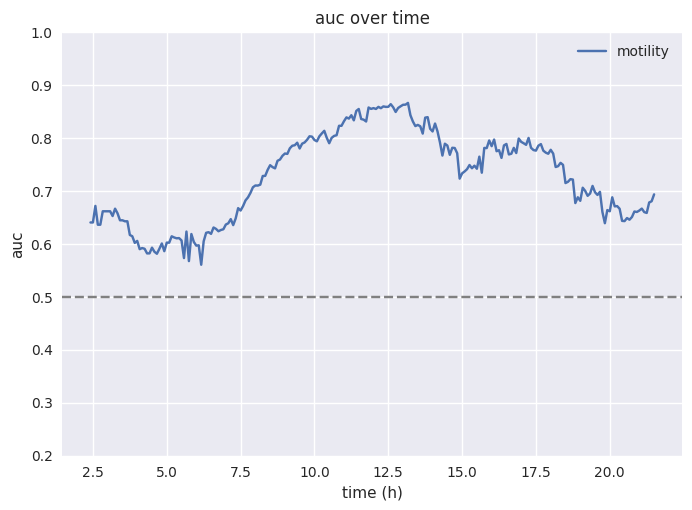

Evaluation metrics for motility based model, tested on videos (s1, s5):
accuracy: 0.727
specificity: 0.583
sensitivity (recall): 0.978
precision: 0.573
AUC: 0.78


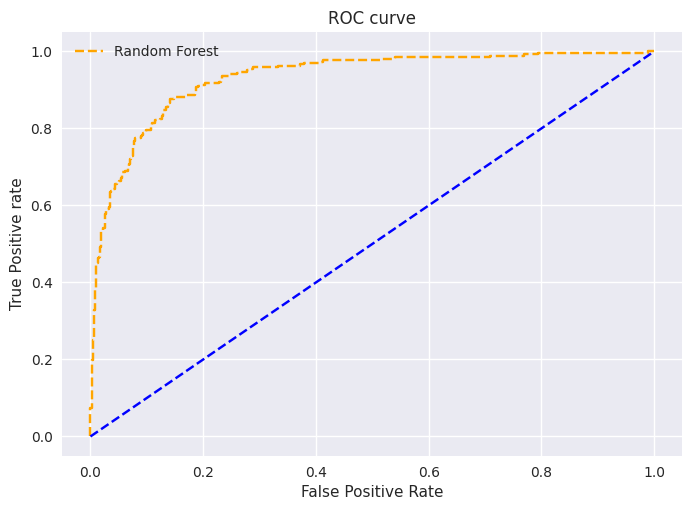

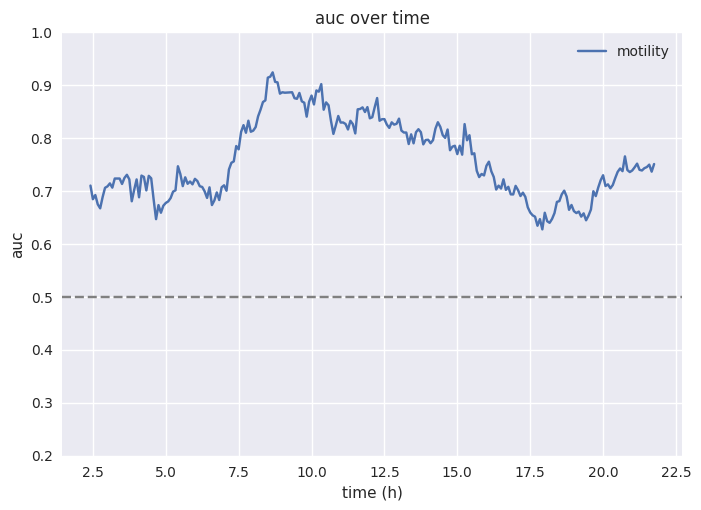

Evaluation metrics for actin_intensity based model, tested on videos (s2, s3):
accuracy: 0.808
specificity: 0.794
sensitivity (recall): 0.813
precision: 0.927
AUC: 0.804


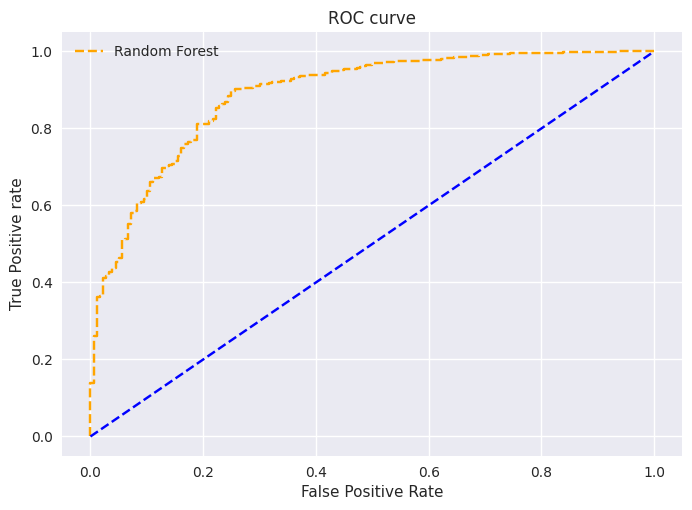

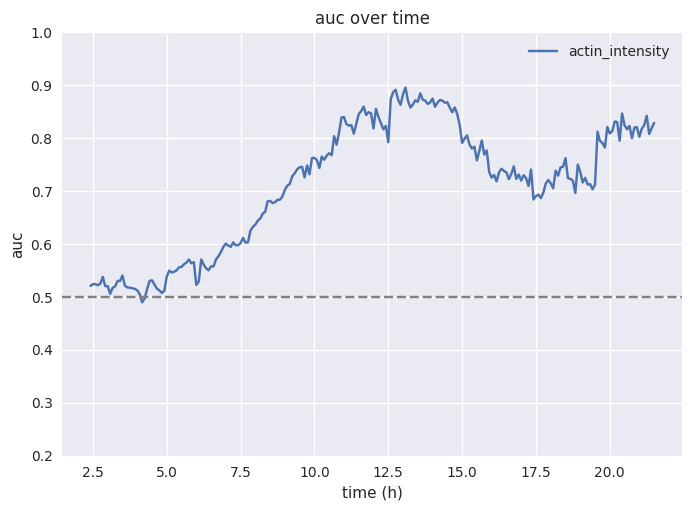

Evaluation metrics for actin_intensity based model, tested on videos (s1, s5):
accuracy: 0.73
specificity: 0.647
sensitivity (recall): 0.873
precision: 0.591
AUC: 0.76


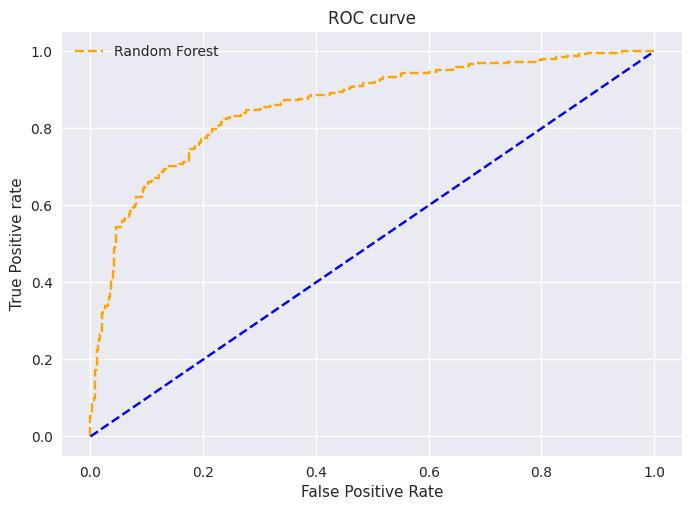

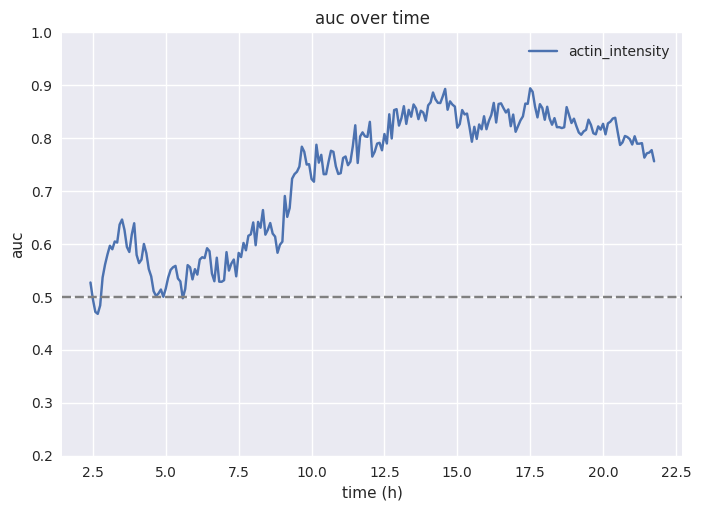

<Figure size 800x550 with 0 Axes>

In [4]:
train_vid_nums = [(1,5), (2,3)]
test_vid_nums = [(2,3), (1,5)]
modalities = ["motility", "actin_intensity"]

for modality in modalities:
    for (con_train_n, diff_train_n), (con_test_n, diff_test_n) in zip(train_vid_nums, test_vid_nums):
        data_path = consts.intensity_model_path if modality == "actin_intensity" else consts.motility_model_path
        data_path = data_path % (con_train_n, diff_train_n)
        clf, _, x_test, _, y_test = data_utils.load_data(data_path, load_clf=True, load_x_train=False, load_x_test=True, load_y_train=False, load_y_test=True)
        utils.evaluate_model(clf, x_test, y_test, modality, con_test_n, diff_test_n)

# Differentiation score over time

In [5]:
fig_dir_path = fr"/storage/users/assafzar/Muscle_Differentiation_AvinoamLab/eps_figs/"

S2, S3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


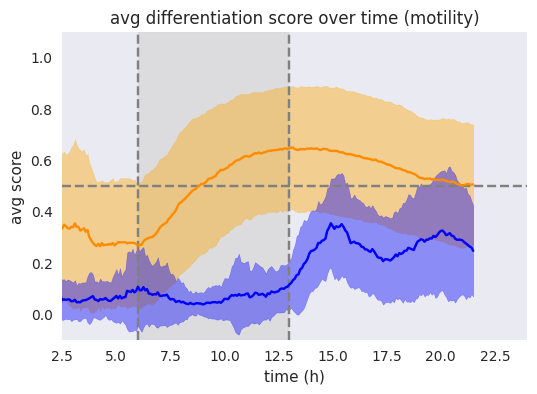

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 800x550 with 0 Axes>

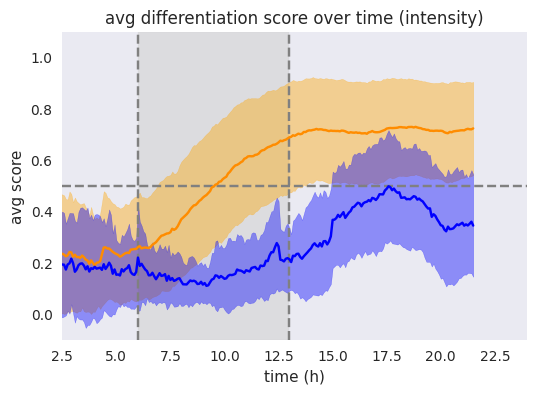

<Figure size 800x550 with 0 Axes>

In [6]:
data_2_3_test  = [(scores_df_s3, "ERKi", "DarkOrange","Orange"), (scores_df_s2, "DMSO", "blue", "blue"),]
utils.plot_avg_conf(data_2_3_test, "motility", path=fig_dir_path + "avg diff over time train (1,5) test (2,3) motility", plot_std=True, time=(6,13), xlim=(2.5, 24))
utils.plot_avg_conf(data_2_3_test, "intensity", path=fig_dir_path + "avg diff over time train (1,5) test (2,3) intensity", plot_std=True, time=(6,13), xlim=(2.5, 24))

S1, S5

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


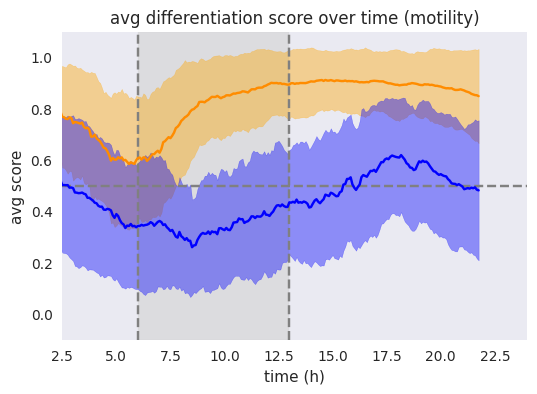

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 800x550 with 0 Axes>

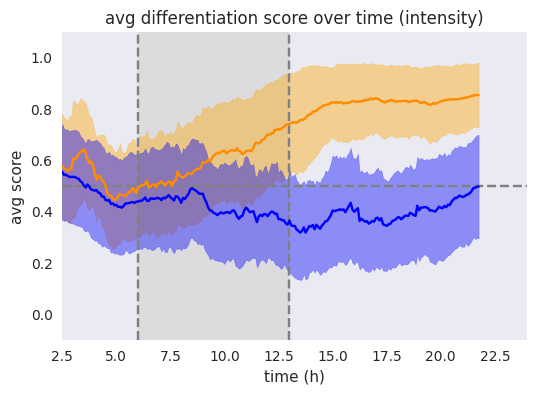

<Figure size 800x550 with 0 Axes>

In [7]:
data_1_5_test  = [(scores_df_s5, "ERKi", "DarkOrange","Orange"), (scores_df_s1, "DMSO", "blue", "blue"),]
utils.plot_avg_conf(data_1_5_test, "motility", path=fig_dir_path + "avg diff over time train (1,5) test (2,3) motility", plot_std=True, time=(6,13), xlim=(2.5, 24))
utils.plot_avg_conf(data_1_5_test, "intensity", path=fig_dir_path + "avg diff over time train (1,5) test (2,3) intensity", plot_std=True, time=(6,13), xlim=(2.5, 24))

### Monotonicity

In [8]:
def plot_monotonicity_dist(df, vid_name, time, rolling_w, modality, color):
    """
    Calculates monotonicity rates for single cells and plots the distribution 
    :pararm df: (pd.DataFrame) single cell's track dataframe, with differntiation scores by motility & actin intensity models
    :pararm vid_name: (Str) name of video the data eas extracted from.
    :pararm time: (tuple) time range to calculate correlationin (start_time, end_time).
    :pararm rolling_w: (int) size of window for rolling average smoothing.
    :pararm modality: (Str) "motility"/"intensity".
    """
    mono_values = []
    for track_id, track_df in df.groupby("Spot track ID"):
        if len(track_df) > rolling_w:
            mono = calculator.get_monotonicity(track_df, modality, time, rolling_w)
            mono_values.append(mono)
            
    mean = round(np.nanmean(mono_values),3)
    median = round(np.nanmedian(mono_values),3)
    
    sns.histplot(mono_values, stat="percent", bins=10, color=color)
    plt.axvline(median, linestyle='dashed', color="black")
    plt.savefig(consts.storage_path + f"eps_figs/monotonicity distribution vid {vid_name} {modality}.eps", format="eps")
    plt.show()
    
    print(modality, "mean", mean, "median", median)
    print("Number of cells in this analysis: ", len(mono_values))

S3 video (ERK)

In [9]:
plot_monotonicity_dist(scores_df_s3, "S3", time=(6,13), rolling_w=5, modality="intensity", color="red")
plot_monotonicity_dist(scores_df_s3, "S3", time=(6,13), rolling_w=5, modality="motility", color="yellow")

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

S5 video (ERK)

In [ ]:
plot_monotonicity_dist(scores_df_s5, "S5", time=(6,13), rolling_w=5, modality="intensity", color="red")
plot_monotonicity_dist(scores_df_s5, "S5", time=(6,13), rolling_w=5, modality="motility", color="yellow")

## Duration of differentiation process

In [ ]:
def print_distribution_statistitics(data, x_label, added_text=""):
    print("#cells ",added_text, len(data))

    mean, median, std = data[x_label].mean(), data[x_label].median(), data[x_label].std()
    print(added_text, "mean-", round(mean, 3), "median-",  round(median, 3), "std-", round(std, 3))
    
    normal_test_pvalue = normaltest(data[x_label], nan_policy='omit')[1]
    print(added_text, "normality test diff time: p-value", normal_test_pvalue)

    
def get_diff_process_dist_values(df, low_thresh=(0.2, 0.3), high_thresh=(0.7, 0.8)):
    """ 
    The duration of the single-cell differentiation process is determined as the  time passed from reaching a low, 
    stable threshold to reaching a high stable threshold in the differentiation scores. The low, stable threshold is defined as the 
    last time point of the longest sequence with differentiation scores that ranged between 0.2-0.3. The high stable threshold is 
    defined as the first time point of the longest sequence with differentiation scores that ranged between 0.7-0.8. 
    The differentiation process duration was calculated as the time passed between the low and high stable thresholds.
    :param df: (pd.DataFrame) differntiation scores by motility & actin intensity models
    :param vid_name: (Str) name of video the data eas extracted from.
    :param low_thresh: (float, float) differentiation scores low threshold range 
    :param high_thresh: (float, float) differentiation scores high threshold range 
    :return df_to_plot: (pd.DataFrame) duration distributions ny motility & actin intensity models
    """
    def get_dist_values(modality, high_thresh, low_thresh, df):
        duration_values = []
        start_time_values = []
        for track_id, track_df in df.groupby("Spot track ID"):
            high_thresh_time = calculator.get_stable_threshold_time(track_df, high_thresh, modality, time_point="first")
            low_thresh_time = calculator.get_stable_threshold_time(track_df, low_thresh, modality, time_point="last", time_thresh=high_thresh_time)
            duration = high_thresh_time - low_thresh_time
            duration_values.append(duration)
            start_time_values.append(low_thresh_time)
        df = pd.DataFrame({"duration": duration_values, "start_time": start_time_values, "model type": f"{modality}"})
        return df
    
    # get data
    df_mot = get_dist_values("motility", high_thresh, low_thresh, df).dropna()
    df_int = get_dist_values("intensity", high_thresh, low_thresh, df).dropna()
    df_to_plot = pd.concat([df_mot, df_int], ignore_index=True, axis=0)
    
    # print some statistics & info
    total_cells_num = df["Spot track ID"].nunique()
    print("#cells in the analysis: ", total_cells_num)
    print("=======================")
    print("\nduration statistics:")
    print_distribution_statistitics(df_mot, "duration", added_text="motility: ")
    print_distribution_statistitics(df_int, "duration", added_text="actin intensity: ")
    print("=======================")
    print("\nstart_time statistics:")
    print_distribution_statistitics(df_mot, "start_time", added_text="motility: ")
    print_distribution_statistitics(df_int, "start_time", added_text="actin intensity: ")
          
    return df_to_plot

def plot_distribution(df_to_plot, vid_name, x_label):
    # plot the distributions
    median_mot = df_to_plot[df_to_plot["model type"] == f"motility"][x_label].median()
    median_int = df_to_plot[df_to_plot["model type"] == f"intensity"][x_label].median()
    
    catplot = sns.catplot(data=df_to_plot, x=x_label, y="model type", kind="violin", color=".9", inner=None)
    swarmplot = sns.swarmplot(data=df_to_plot, x=x_label, y="model type", size=3) 
    plt.axvline(median_mot, color='blue', linestyle='dashed')
    plt.axvline(median_int, color='orange', linestyle='dashed')
    plt.xticks(range(int(df_to_plot[x_label].max())+1))
    plt.savefig(consts.storage_path + f"eps_figs/diff {x_label} distribution over time vid {vid_name}.eps", format="eps")
    plt.show()

In [ ]:
durations_df = get_diff_process_dist_values(scores_df_s3)
plot_distribution(durations_df, "S3", "duration")
plot_distribution(durations_df, "S3", "start_time")

In [ ]:
durations_df = get_diff_process_dist_values(scores_df_s5)
plot_distribution(durations_df, "S5", "duration")
plot_distribution(durations_df, "S5", "start_time")

In [ ]:
scores_df_s3 = data_utils.get_scores_df_with_fusion()

In [ ]:
track_ids = [217, 18989,  16771, 9241, 1394, 16991, 16003, 19228, 23080, 16091, 4657, 27879, 8662, 8598, 14320]
track_ids = [4657, 16003, 27879, 8598]
track_ids_random = np.random.choice(track_ids, 4, replace=False)

path = consts.storage_path + "/eps_figs/monotonicity_ordered_trajectories/"
utils.plot_diff_trajectories_single_cells([(scores_df_s3[scores_df_s3["Spot track ID"].isin(track_ids_random)], "ERK")], "motility", None , rolling_w=1)
utils.plot_diff_trajectories_single_cells([(scores_df_s3[scores_df_s3["Spot track ID"].isin(track_ids_random)], "ERK")], "intensity", None, rolling_w=1)

In [ ]:
def plot_all_cells(conf_data, modality, path=None, rolling_w=1):
    def plot(df, label, modality):
        for track_id, track in df.groupby("Spot track ID"):
            track = track[(track["Spot frame"]<=track["fusion_frame"])].sort_values("time")
            track[f"score_{modality}"] = track[f"score_{modality}"].rolling(rolling_w).mean()
            monotonicity = get_corr_values(track, (6,13), f"score_{modality}", "time", rolling_w=6, corr_metric="spearman")[0]
            plt.plot(track["time"], track[f"score_{modality}"], linewidth=1, color=cmap(monotonicity), label=track_id)
    
    fig = plt.figure(figsize=(6, 3))
    cmap = mpl.cm.get_cmap('rainbow')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=-0, vmax=1))
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(-1, 1, 5))
    
    for (df, label) in conf_data:
        plot(df, label, modality)

    plt.axhline(0.5, color='black', linestyle='dashed')
    plt.xlabel("time (h)")
    plt.ylabel("avg score")    
    plt.title(f"avg differentiation score over time ({modality})")
    plt.ylim((0,1))
    plt.xlim((4,21))
    plt.legend()
    if path:
        plt.savefig(path + "/" + f'examplary_tracks_{modality}.eps', format="eps")
    plt.show()
    plt.clf()

ids_15_12_mot = [12526, 10528, 4657, 3637, 8598, 27879, 28929]
for ids in list(itertools.combinations(ids_15_12_mot, 3))[6:8]:
    print(ids)
    plot_all_cells([(scores_df_s3[scores_df_s3["Spot track ID"].isin(ids)], "ERK")], "intensity", None , rolling_w=1)
    plot_all_cells([(scores_df_s3[scores_df_s3["Spot track ID"].isin(ids)], "ERK")], "motility", None , rolling_w=1)